#DETECCIÓN DE DETALLES EN ROSTROS CON CNN Y KERAS
En este notebook usaremos el dataset ofrecido gratuitamente por kaggle [facial-keypoints](https://www.kaggle.com/c/facial-keypoints-detection) para hacer deteccion de detalles en el rostro humano.
El dataset esta compuesto por imágenes de tamaño 96x96 en escala de grises junto con 15 marcos faciales que sobresaltan las cejas los ojos la boca y la nariz.

El objetivo es crear un algoritmo que aprenda los patrones de esos datos y pueda predecir nuevos marcos para fotos de rostros nuevas 


In [0]:
!pip install watermark

In [0]:
#importamos los modulo
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import matplotlib
import os


In [3]:
# version de los paquetes usados
%reload_ext watermark
%watermark -a "Christian Arcos Gordillo" --iversion

numpy      1.18.2
matplotlib 3.2.1
tensorflow 2.2.0-rc2
Christian Arcos Gordillo


#Importar Dataset

In [4]:
from google.colab import files
uploaded = files.upload()

Saving training.csv to training.csv


In [5]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [0]:
#importar los aarchivos 
TRAIN = 'training.csv'
TEST = 'test.csv'

def load(test = False):
  # si test es True se descargan los datos de entrenamiento caso contrario solo se descargan los de entrenamiento

  fname = TEST if test else TRAIN
  df = read_csv(os.path.expanduser(fname))

  #la columna Imagen tiene valores de pixel separados por espacios
  #los convertimos para array numpy
  df['Image'] = df['Image'].apply(lambda x:np.fromstring(x, sep=' ')) #conversion de un string a array separados por espacios

  # eliminar todas las columnas con datos faltantes
  df = df.dropna()

  #normalizar los pixels entre [0,1]
  X =np.vstack(df['Image'].values)/255. #apilamos los valores en una sola columna
  X = X.astype(np.float32)
  print("antes del reshape",X.shape)
  X = X.reshape(-1, 96, 96, 1) # le damos el formato a todos los registros de 96 x96 
  print("despues",X.shape)

  #buscar las etiquetas
  if not test:
    y= df[df.columns[:-1]].values
    y=(y-48)/48 # escalar entre -1 y1 

    #mezclar los datos de entrenamiento
    X,y = shuffle(X,y, random_state=42)

  else:
    y=None

  return X,y

In [8]:
#cargando datos  de entrenamiento
X,y = load()
print("X.shape == {}".format(X.shape))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

anes del reshape (2140, 9216)
despues (2140, 96, 96, 1)
X.shape == (2140, 96, 96, 1)
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996


In [9]:
#cargando los datos de tes
X_test,_=load(test=True)
print("X_test.shape == {}".format(X_test.shape))

anes del reshape (1783, 9216)
despues (1783, 96, 96, 1)
X_test.shape == (1783, 96, 96, 1)


##Visualizando Subset de datos de entrenamiento

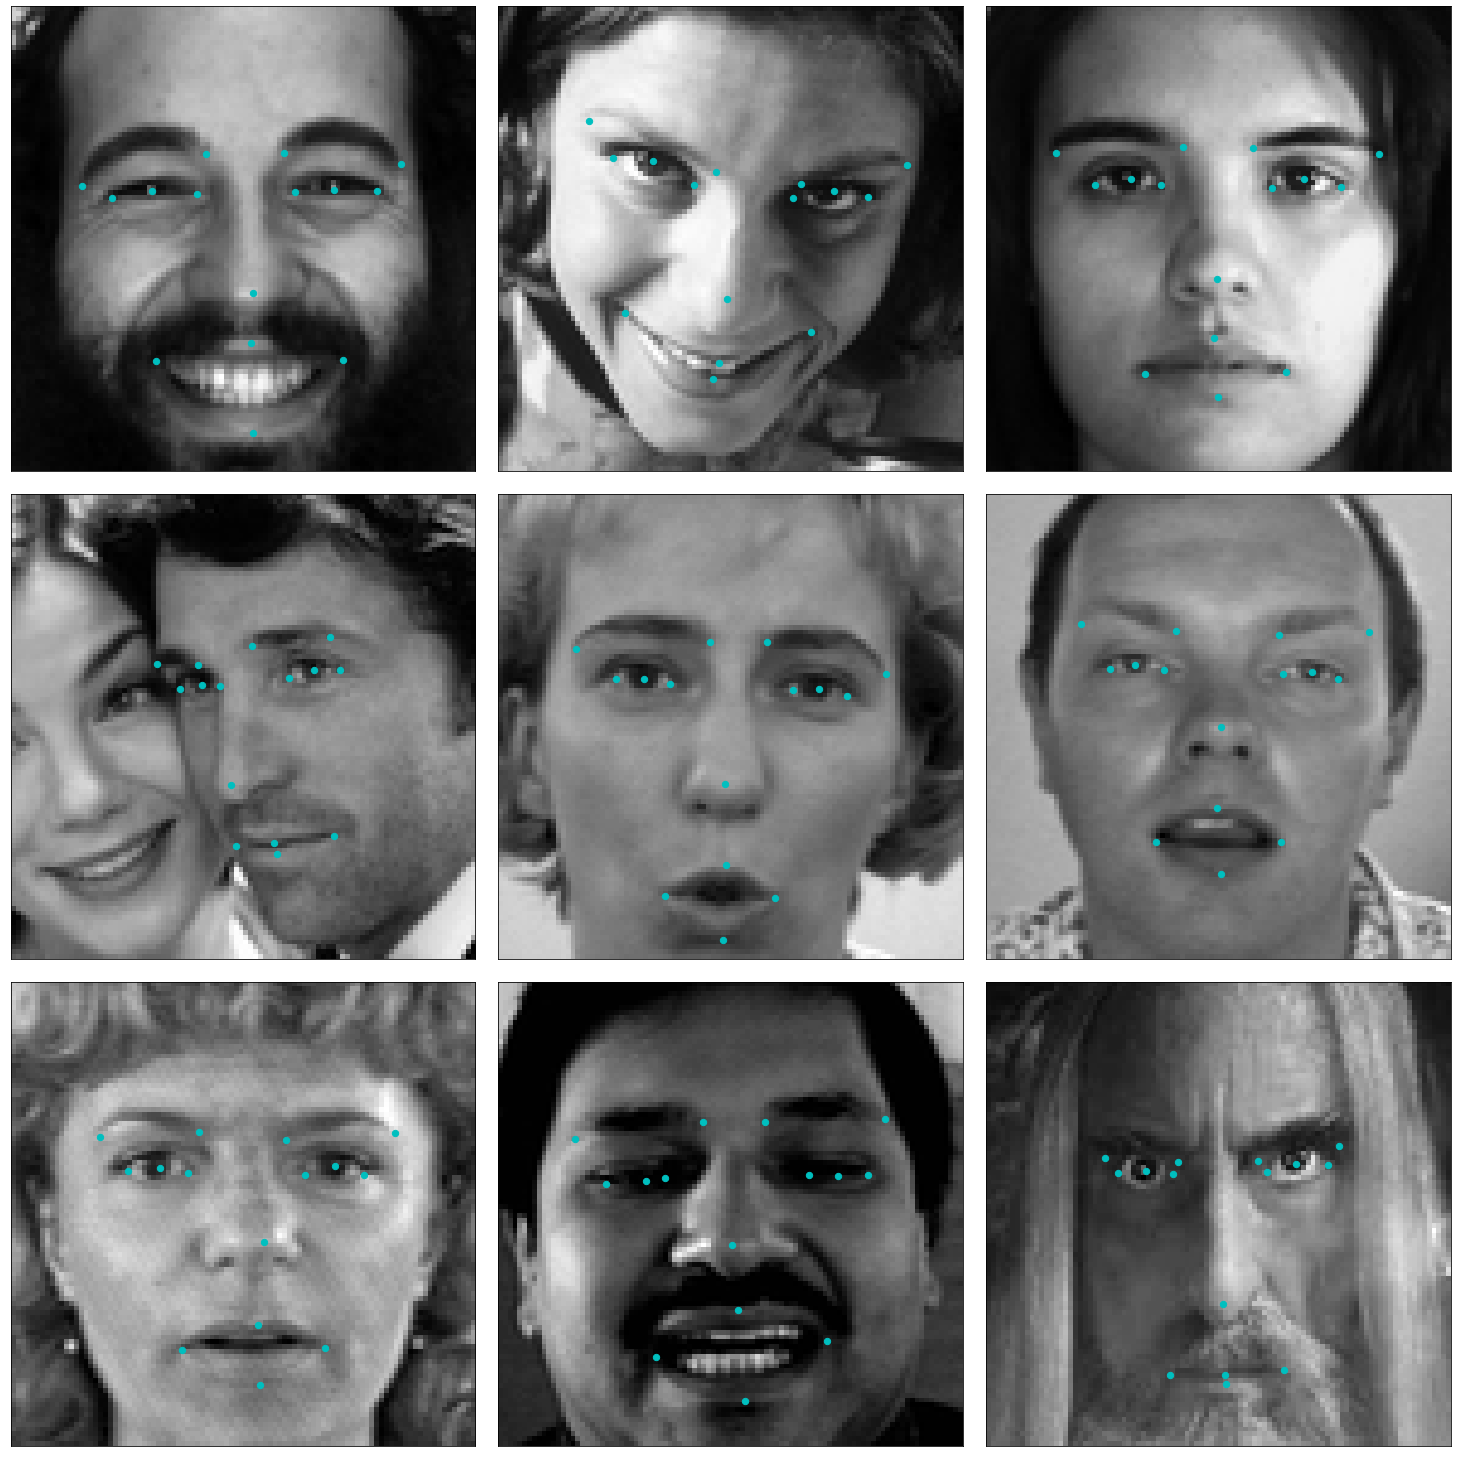

In [14]:
def plot_data(img, landmarks, axis):
  axis.imshow(np.squeeze(img),cmap='gray')
  axis.scatter(landmarks[0::2]*48 + 48,landmarks[1::2]*48 + 48, marker ='o', c='c', s=40)

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0 , right=1, bottom=0, top=1, hspace=0.05,wspace=0.05)
for i in range(9):
  ax = fig.add_subplot(3,3,i+1,xticks=[],yticks=[])
  plot_data(X[i],y[i],ax)

##Arquitectura del modelo

In [15]:
model = tf.keras.models.Sequential()

#primera etapa de convolución
model.add(tf.keras.layers.Conv2D(32 , 3, activation='relu', input_shape = [96,96,1]))

#capa de pooling
model.add(tf.keras.layers.MaxPool2D((2,2)))

#segunda capa de convolución 
model.add(tf.keras.layers.Conv2D(64 , 3, activation='relu'))

#capa de pooling
model.add(tf.keras.layers.MaxPool2D((2,2)))

#tercera capa de convolución 
model.add(tf.keras.layers.Conv2D(128 , 3, activation='relu'))

#capa de pooling
model.add(tf.keras.layers.MaxPool2D((2,2)))

#convertimos a un solo vector
model.add(tf.keras.layers.Flatten())

#primera capa totalmente conectada
model.add(tf.keras.layers.Dense(500,activation='relu'))

#segunda capa densa
model.add(tf.keras.layers.Dense(30))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0

##Entrnamiento del modelo


In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,nesterov=True)
model.compile(optimizer=optimizer, loss='mse')
hist = model.fit(X,y,epochs=500,validation_split=0.2)

Epoch 1/500
54/54 [==============================] - 28s 511ms/step - loss: 0.0278 - val_loss: 0.0071
Epoch 2/500
54/54 [==============================] - 27s 495ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 3/500
54/54 [==============================] - 27s 497ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 4/500
54/54 [==============================] - 27s 497ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 5/500
54/54 [==============================] - 27s 496ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 6/500
54/54 [==============================] - 27s 497ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 7/500
54/54 [==============================] - 27s 499ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 8/500
54/54 [==============================] - 27s 499ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 9/500
54/54 [==============================] - 27s 499ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 10/500
54/54 [==============================] - 27s 499ms/step - loss: 0.004

#Visualizando un Subset de Predicciones

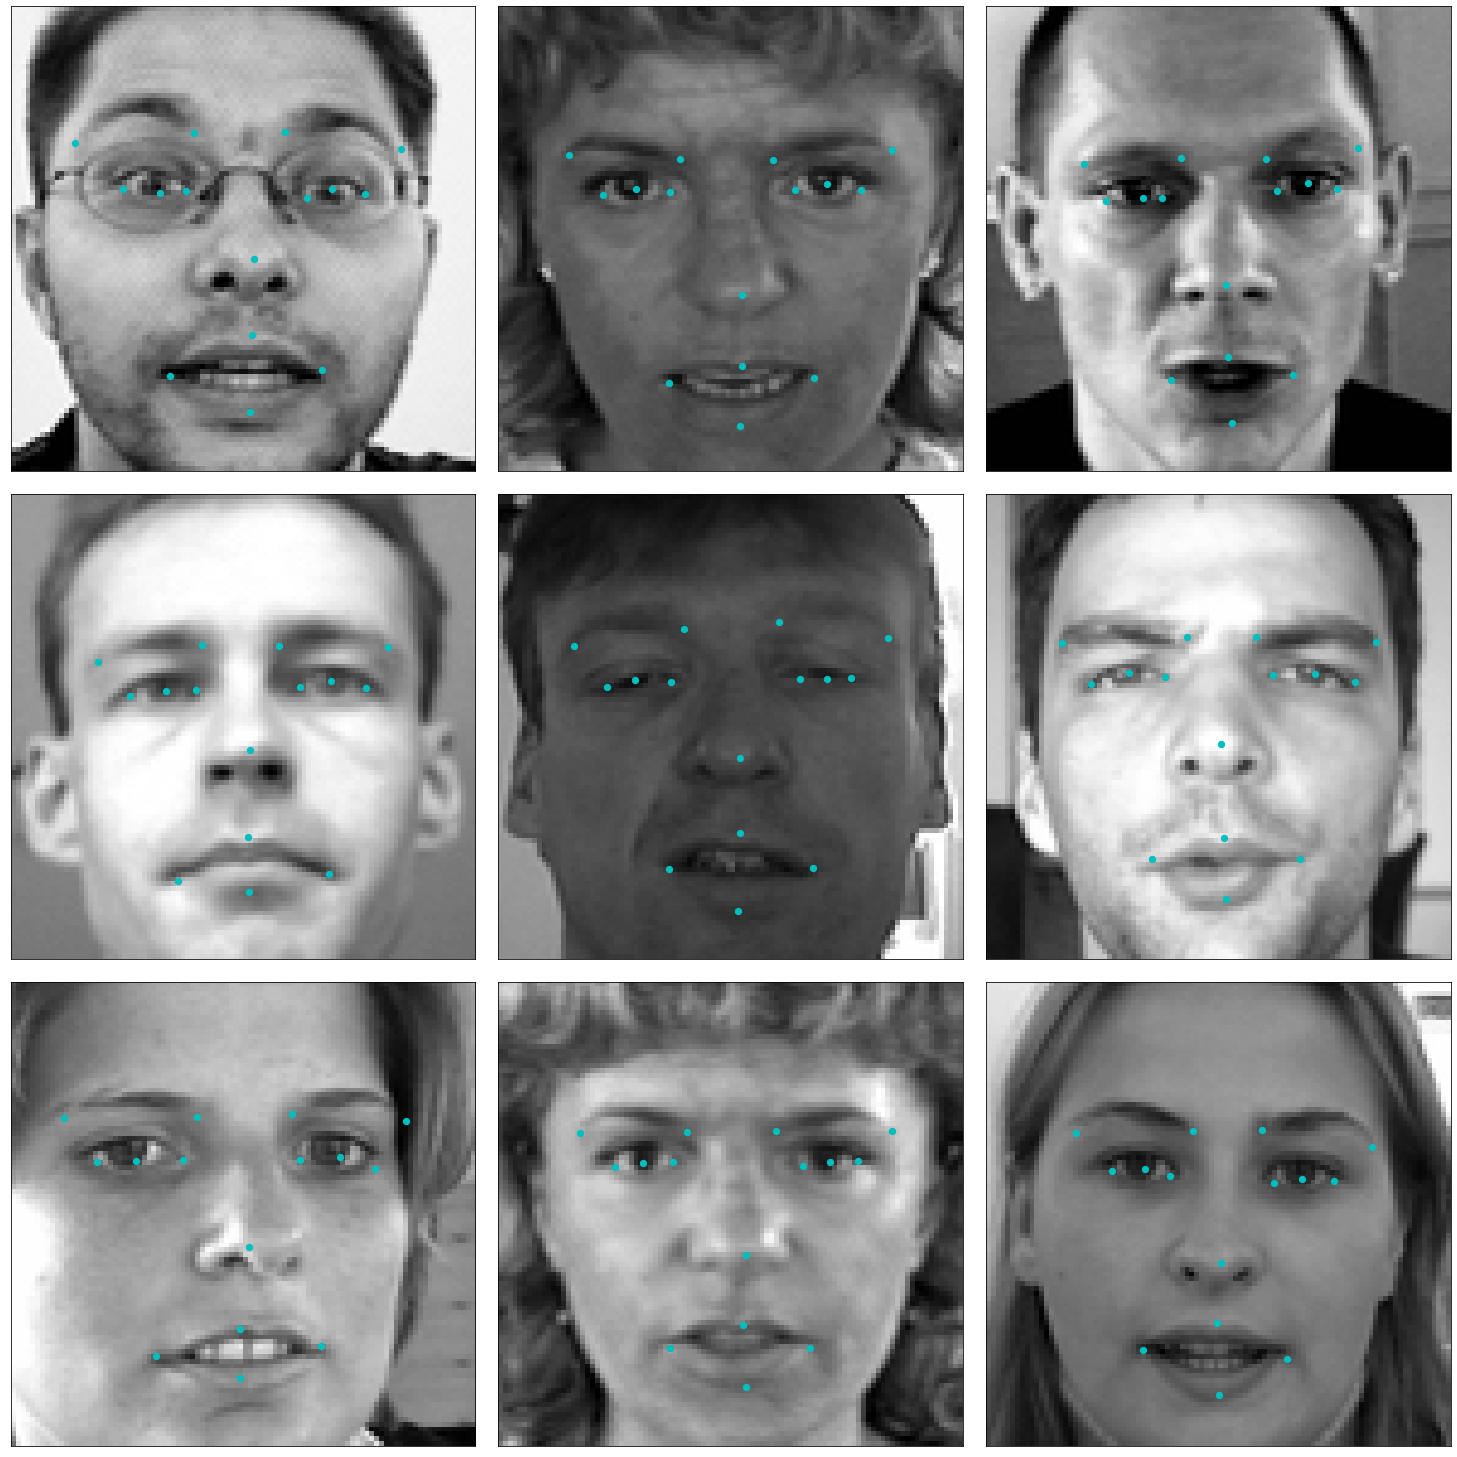

In [17]:
y_test = model.predict(X_test)
fig =plt.figure(figsize=(20,20))
fig.subplots_adjust(left = 0, right =1, bottom = 0, top =1, hspace =0.05,wspace=0.05)
for i in range (9):
  ax = fig.add_subplot(3,3,i+1,xticks=[], yticks=[])
  plot_data(X_test[i], y_test[i], ax)